In [264]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import joblib
from sklearn.model_selection import KFold

In [265]:
data = pd.read_csv('bio copy.csv')
gender = {"M":1,"F":0}
data["Gender"] = data["Gender"].map(gender)
data.dropna(inplace=True)
data.drop(34, inplace=True)
data.reset_index(drop=True, inplace=True)
X = data[["Age","Gender","BMI","Body weight ","Height "]].values
data["HOMA-IR"] = data["Fasting GLU - PDL (Lab)"] * data["Insulin "] / 405
y = data["HOMA-IR"].values.reshape(-1, 1)

In [266]:
x_scaler = StandardScaler()
y_scaler = StandardScaler()
X_scaled = x_scaler.fit_transform(X)
y_scaled = y_scaler.fit_transform(y)
joblib.dump(x_scaler, 'x_scaler.pkl')
joblib.dump(y_scaler, 'y_scaler.pkl')
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y_scaled, dtype=torch.float32)

In [267]:
class RegressionNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(5, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1),
        )

    def forward(self, x):
        return self.model(x)

Early stopping at epoch 4
Fold 1 R²: -0.3831


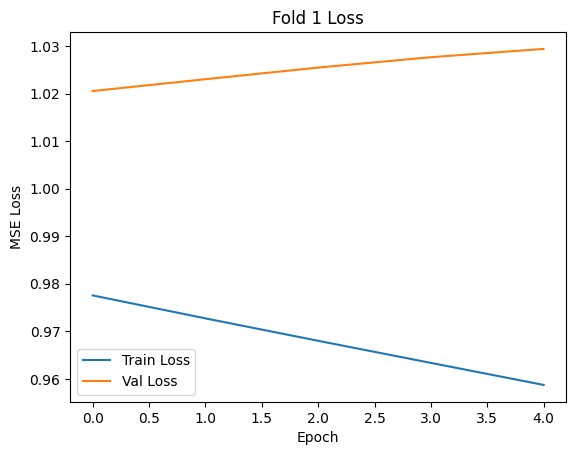

Early stopping at epoch 134
Fold 1 R²: 0.6018


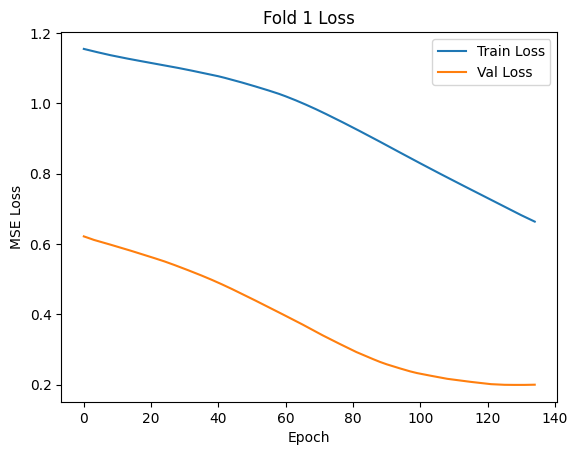

Early stopping at epoch 4
Fold 1 R²: -0.0158


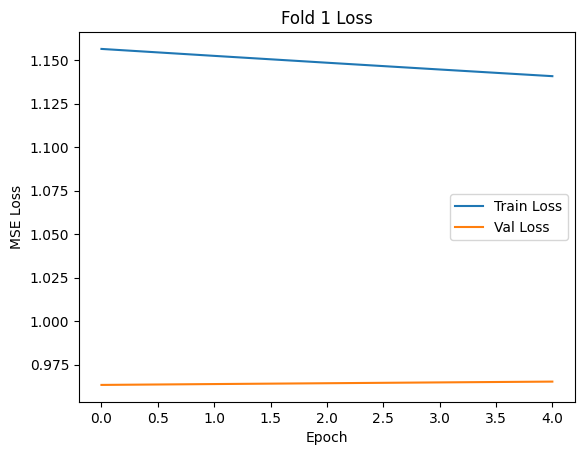

Early stopping at epoch 150
Fold 1 R²: 0.1317


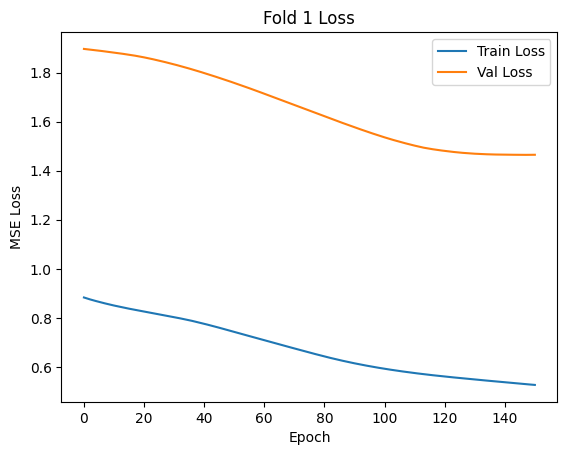

Early stopping at epoch 100
Fold 1 R²: -0.3053


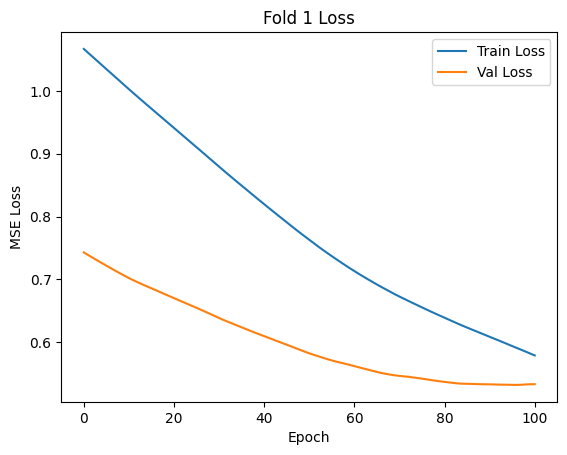


Average R² across folds: 0.0058


In [269]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold = 1
all_r2_scores = []
for train_index, test_index in kf.split(X_tensor):
    X_train, X_test = X_tensor[train_index], X_tensor[test_index]
    y_train, y_test = y_tensor[train_index], y_tensor[test_index]

    model = RegressionNN()
    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001)
    best_loss = float('inf')
    patience = 4
    trigger_times = 0
    best_model_state = None
    train_losses = []
    val_losses = []
    num_epochs = 1000

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        val_loss = criterion(model(X_test), y_test).item()
        train_losses.append(loss.item())
        val_losses.append(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_state = model.state_dict()
            trigger_times = 0
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print(f"Early stopping at epoch {epoch}")
                break
    
    model.load_state_dict(best_model_state)
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test).numpy()
        y_pred_inv = y_scaler.inverse_transform(y_pred)
        y_val_inv = y_scaler.inverse_transform(y_test.numpy())
        r2 = r2_score(y_val_inv, y_pred_inv)
        all_r2_scores.append(r2)
        print(f"Fold {fold} R²: {r2:.4f}")

    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.title(f"Fold {fold} Loss")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.legend()
    plt.show()

print(f"\nAverage R² across folds: {np.mean(all_r2_scores):.4f}")


In [ ]:
torch.save(best_model_state, 'model.pth')

In [244]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
x_scaler = StandardScaler()
y_scaler = StandardScaler()
X_train_scaled = x_scaler.fit_transform(X_train)
X_test_scaled = x_scaler.transform(X_test)
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

Epoch [1/10000], Loss: 1.1292, Val Loss: 0.2078
Epoch [2/10000], Loss: 1.1222, Val Loss: 0.2043
Epoch [3/10000], Loss: 1.1153, Val Loss: 0.2007
Epoch [4/10000], Loss: 1.1083, Val Loss: 0.1972
Epoch [5/10000], Loss: 1.1012, Val Loss: 0.1937
Epoch [6/10000], Loss: 1.0941, Val Loss: 0.1903
Epoch [7/10000], Loss: 1.0870, Val Loss: 0.1869
Epoch [8/10000], Loss: 1.0798, Val Loss: 0.1836
Epoch [9/10000], Loss: 1.0727, Val Loss: 0.1802
Epoch [10/10000], Loss: 1.0656, Val Loss: 0.1769
Epoch [11/10000], Loss: 1.0584, Val Loss: 0.1737
Epoch [12/10000], Loss: 1.0513, Val Loss: 0.1703
Epoch [13/10000], Loss: 1.0441, Val Loss: 0.1668
Epoch [14/10000], Loss: 1.0370, Val Loss: 0.1635
Epoch [15/10000], Loss: 1.0299, Val Loss: 0.1602
Epoch [16/10000], Loss: 1.0228, Val Loss: 0.1570
Epoch [17/10000], Loss: 1.0156, Val Loss: 0.1538
Epoch [18/10000], Loss: 1.0085, Val Loss: 0.1505
Epoch [19/10000], Loss: 1.0013, Val Loss: 0.1473
Epoch [20/10000], Loss: 0.9942, Val Loss: 0.1441
Epoch [21/10000], Loss: 0.987

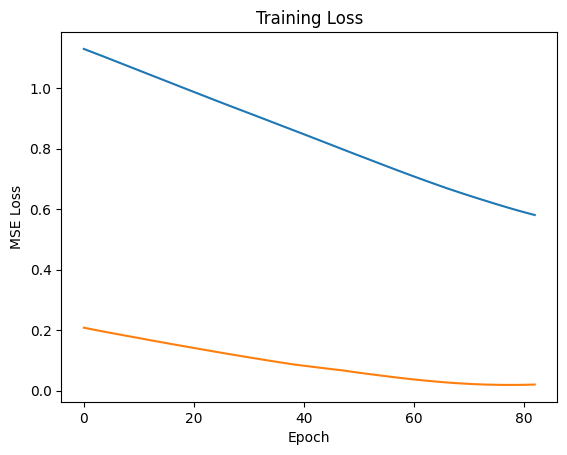

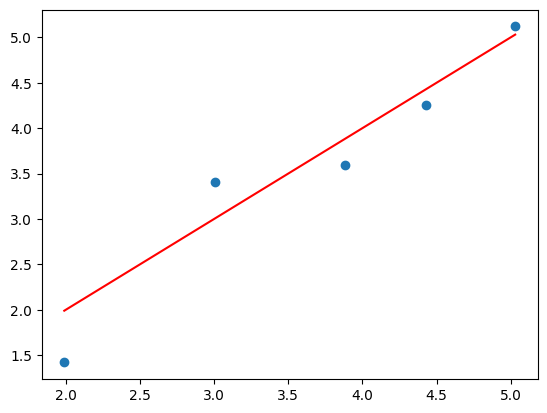

R² value: 0.8935


In [246]:
# No Overfitting
best_model_state = None

losses = []
val_losses = []
best_loss = float('inf')
patience = 4
trigger_times = 0
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    
    
    val_loss = criterion(model(X_test_tensor), y_test_tensor).item()
    val_losses.append(val_loss)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}")
    if val_loss < best_loss:
        best_loss = val_loss
        best_model = model.state_dict()
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f"Early stopping at epoch {epoch}")
            model.load_state_dict(best_model)
            break

plt.plot(losses)
plt.plot(val_losses)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training Loss")
plt.show()

model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor).numpy()
    predictions = y_scaler.inverse_transform(predictions)
    y_true = y_scaler.inverse_transform(y_test_tensor.numpy())

# Plot predictions vs actual
plt.scatter(y_true, predictions)

plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red')
plt.show()

r2 = r2_score(y_true, predictions)
print(f"R² value: {r2:.4f}")
torch.save(best_model_state, 'model.pth')

In [247]:
torch.save(model.state_dict(), 'model.pth')

In [252]:
joblib.dump(x_scaler, 'x_scaler.joblib')
joblib.dump(y_scaler, 'y_scaler.joblib')

['y_scaler.joblib']

In [ ]:
x_scaler = StandardScaler()
y_scaler = StandardScaler()
X_scaled = x_scaler.fit_transform(X)
y_scaled = y_scaler.fit_transform(y)
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y_scaled, dtype=torch.float32)

Epoch [1/10000], Loss: 0.0010, Val Loss: 0.0010
Epoch [2/10000], Loss: 0.0010, Val Loss: 0.0010
Epoch [3/10000], Loss: 0.0010, Val Loss: 0.0010
Epoch [4/10000], Loss: 0.0010, Val Loss: 0.0010
Epoch [5/10000], Loss: 0.0010, Val Loss: 0.0010
Early stopping at epoch 4


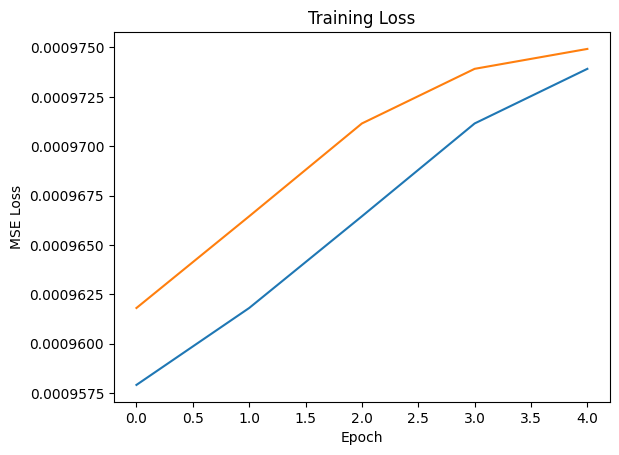

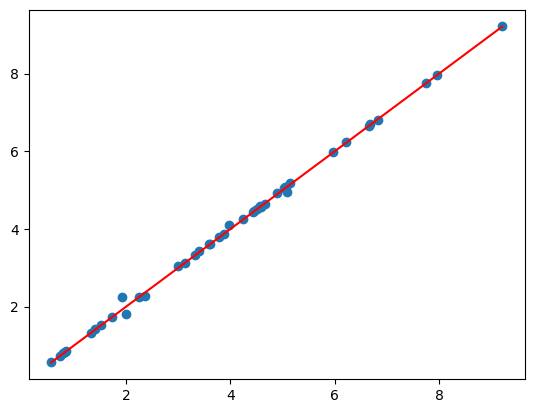

R² value: 0.9990


In [ ]:
# Overfitting
best_model_state = None

losses = []
val_losses = []
best_loss = float('inf')
patience = 4
trigger_times = 0
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_tensor)
    loss = criterion(outputs, y_tensor)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    
    
    val_loss = criterion(model(X_tensor), y_tensor).item()
    val_losses.append(val_loss)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}")
    if val_loss < best_loss:
        best_loss = val_loss
        best_model = model.state_dict()
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f"Early stopping at epoch {epoch}")
            model.load_state_dict(best_model)
            break

plt.plot(losses)
plt.plot(val_losses)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training Loss")
plt.show()

model.eval()
with torch.no_grad():
    predictions = model(X_tensor).numpy()
    predictions = y_scaler.inverse_transform(predictions)
    y_true = y_scaler.inverse_transform(y_tensor.numpy())

# Plot predictions vs actual
plt.scatter(y_true, predictions)

plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red')
plt.show()

r2 = r2_score(y_true, predictions)
print(f"R² value: {r2:.4f}")
torch.save(best_model_state, 'model.pth')

In [29]:
model.load_state_dict(torch.load("model.pth"))
model.eval()


TypeError: Expected state_dict to be dict-like, got <class 'NoneType'>.